#imports

In [ ]:
import numpy as np
import scipy as scp
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

#Spring-Mass-Piston System

This is a simple example to demonstrate how optimal control algorithms work. We consider a spring with a block attached on one end and a piston on the other. The signal containing the position of the piston over time is the *control*. We define the *optimal control* for this problem as the signal which causes the spring-mass system to end up with a specific target energy, starting from a particular set of initial conditions.

In this code, the initial conditions have the block starting out stationary and the spring stretched out by 1 unit of length. The target energy is 0, so the optimal control signal will be the 100-length array (containing the position of the piston at 100 discrete time steps) which results in the spring-mass system ending up at equilibrium.

In [ ]:
#initial conditions

x = 1; #displacement
v = 0; #velocity
k = .5; #spring constant
m = 1; #mass
l = 2; #spring length at equilibrium

#optimal control parameters

dt = 1; #time between steps
signal_length = 100;
target_e = 0;

#adding zeros at the end of the signal ensures the piston ends up at the
# same place it started
zero_padding_length = 1; 

In order to know how the control signal affects the spring-mass system, we need to do a physics simulation. (Since this is a simple example, it may be possible to calculate the optimal control analytically, but these types of problems generally have no exact solution). The force on the block is modeled with Hooke's Law: $$F = -k(x-d)$$
And the total energy of the system is given by $$E = \frac12mv^2 + \frac12 k(x-d)^2$$
Where $x$ is the displacement of the block from the initial equilibrium position, and $d$ is the displacement of the piston from its initial position.

In [ ]:
#Energy formula for a spring with displacement x, velocity v,
# spring constant k, mass m, and piston position d
def energy(x,v,k,m, d):
    return .5*m*v**2 + .5*k*(x-d)**2

#append num_zeros zeros to the end of s
def zero_pad_signal(s, num_zeros):
    return np.pad(s, (0,num_zeros))

# displacement x, velocity v, spring constant k, mass m, and piston position d
#returns the updated position and velocity after length of time dt
def time_step(x,v,k,m,dt,d):
    #calculate acceleration using Hooke's law
    a = -1*k*(x-d) / m 

    #'leap-frog' scheme: 
    #half-time-step in v, full-time-step in x, recalculate a, half-time-step in v
    v += a*dt/2
    x += v*dt
    a = -1*k*(x-d) / m
    v += a*dt/2

    return [x,v]
    
#Does the full simulation for a given input signal and initial conditions.
#Returns the complete array of energies, positions, and velocities 
# at each time step
def simulate(signal, x,v,k,m,dt):
    energies = []
    xs = []
    vs = []
    padded_signal = zero_pad_signal(signal, zero_padding_length)
    for d in padded_signal:
        [x,v] = time_step(x,v,k,m,dt,d)
        energies.append(energy(x,v,k,m, d))
        xs.append(x)
        vs.append(v)

    return [energies, xs, vs]
    
#The objective function which we must minimize to find the optimal control.
#To be passed into scp.optimize.minimize
def objective_function(signal, *args):
    [x,v,k,m,dt,target] = args
    
    #run the simulation and extract the final energy
    e = simulate(signal, x,v,k,m,dt)[0][-1]

    #This return value is chosen so that the function is minimized when
    # the final energy of the simulation is equal to the target energy
    return np.abs(e - target)

Now we have an objective function that runs a full physics simulation for a given signal and starting parameters. We can pass it into the Scipy's minimize function, which defaults to using the BFGS algorithm. An array of zeros works fine as an initial guess.

In [ ]:
result = scp.optimize.minimize(objective_function, np.zeros(signal_length), args = (x,v,k,m,dt,target_e))

In [ ]:
#Optional: display the full results from Scipy
print(result)

      fun: 6.820631572366442e-17
 hess_inv: array([[ 0.99916764, -0.00328101, -0.00408917, ..., -0.00381498,
        -0.00385823, -0.00197236],
       [-0.00328101,  0.98793079, -0.0148228 , ..., -0.01394584,
        -0.01391541, -0.00692728],
       [-0.00408917, -0.0148228 ,  0.98185496, ..., -0.01710378,
        -0.01701489, -0.00841856],
       ...,
       [-0.00381498, -0.01394584, -0.01710378, ...,  0.98389524,
        -0.01604902, -0.00796876],
       [-0.00385823, -0.01391541, -0.01701489, ..., -0.01604902,
         0.98405119, -0.0078742 ],
       [-0.00197236, -0.00692728, -0.00841856, ..., -0.00796876,
        -0.0078742 ,  0.99615747]])
      jac: array([ 3.27828499e-10, -3.01355305e-09, -3.86273310e-09, -1.98519976e-09,
        1.62629650e-09,  5.34258915e-09,  7.40366197e-09,  6.62692878e-09,
        3.26461370e-09, -8.84111064e-10, -3.57923764e-09, -3.54980568e-09,
       -9.95327440e-10,  2.83736192e-09,  6.22431450e-09,  7.48974997e-09,
        5.81297733e-09,  1.96769

The optimal control is stored in "result.x". We can run the simulation again using this array to see if we successfully minimized the energy.

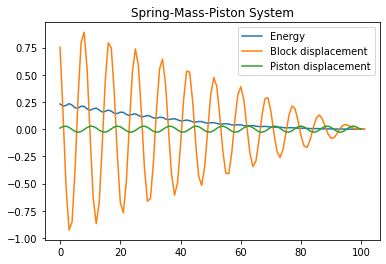

In [ ]:
d = zero_pad_signal(result.x, zero_padding_length)
[es,xs,vs] = simulate(d, x,v,k,m,dt)
plt.plot(es, label='Energy')
plt.plot(xs, label='Block displacement')
plt.plot(d, label='Piston displacement')
plt.title('Spring-Mass-Piston System')
plt.legend()

In the plot we see the block slow down its oscillations, and the energy goes to zero. Now let's look at an animation to see what the optimal control signal looks like.

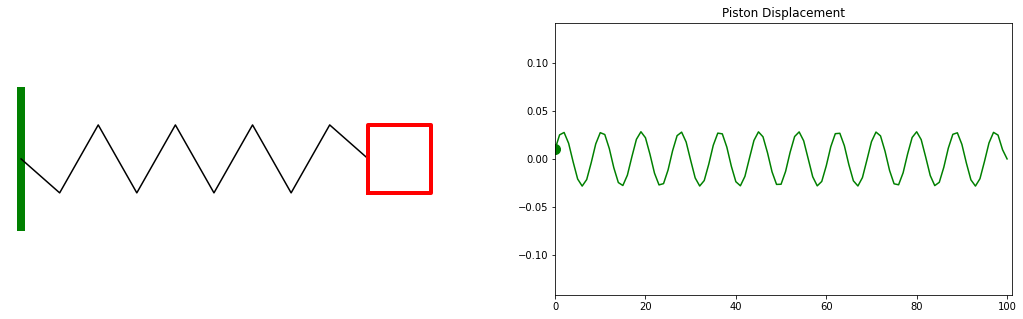

In [ ]:
#graphical options for drawing the spring and block
spring_points = 10
block_width = .5

fig = plt.figure(figsize=(18,5))
ax = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

piston, = ax.plot([], 'g-', lw=8)
spring, = ax.plot([], 'k-')
mass, = ax.plot([], 'r-', lw=4)
ax.set_xlim((-.1, np.max(xs)+np.max(d) + l + block_width + .1))
ax.set_ylim(-1, 1)
ax.axis('off')

ax2.set_xlim((0,len(d)))
ax2.set_ylim((np.min(d)*5,-np.min(d)*5))
ax2.set_title('Piston Displacement')
ax2.plot(d, 'g')

pt, = ax2.plot([], 'go', ms=10)

#The update method to be passed into FuncAnimation
#uses the signal and position data from the minimization and simulate method above
def update(i):
    pt.set_data([i], [d[i]])

    piston.set_data([d[i], d[i]], [-.5,.5])

    mass_x = [d[i] + xs[i] + l, d[i] + xs[i] + l, d[i] + xs[i] + l + block_width, d[i] + xs[i] + l + block_width, d[i] + xs[i] + l]
    mass_y = [-1*block_width / 2, block_width/2, block_width/2, -1*block_width/2, -1*block_width/2]
    mass.set_data(mass_x, mass_y)

    spring_x = np.linspace(d[i], d[i] + xs[i] + l, spring_points)
    spring_y = np.zeros(spring_points)
    for i in range(1, spring_points - 1, 2):
        spring_y[i] = -.25
    for i in range(2, spring_points - 1, 2):
        spring_y[i] = .25
    spring.set_data(spring_x, spring_y)

    return (piston,spring,mass)

ani = FuncAnimation(fig, update, frames=np.arange(len(d)), blit=True, repeat=False)


In [ ]:
#displays the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_html5_video())

Notice that the optimal signal has the piston moving back and forth with the block in order to slow it down. Neat!

#Two spring-mass systems on one piston

Now for a slightly more complicated problem, we'll look at a system of a single piston attached to two different springs, each with a block on the other end. This time, instead of minimizing the total energy of the whole system, we'll set the target energies of both blocks seperately and try to optimize both simultaneously. Here, the target energy for the first block is 0, and the target for the second block is the same as its initial energy. If the optimization is successful, the optimal control will cause the first block to stop moving while the second block continues to oscillate.

In [ ]:
#initial conditions

x = [1,-.5]; #displacement
v = [0,0]; #velocity
k = [.5, 1]; #spring constant
m = [1,1]; #mass
l = [2,2]; #spring length

#optimal control parameters

dt = .5; #time between steps
signal_length = 100;

#The target energies are chosen so that the first block stops moving
# while the second continues to oscillate with its original energy
initial_e2 = energy(x[1], v[1], k[1], m[1], 0)
target_e = [0,initial_e2];

#Using zero padding again for the same reason as before
zero_padding_length = 2;

In [ ]:
#The simulate method is updated so that it calculates the 
# energy, position, and velocity of both blocks
def simulate_two(signal, x,v,k,m,dt):
    energies = []
    xs = []
    vs = []
    for i in range(2):
        xi = x[i]
        vi = v[i]
        padded_signal = zero_pad_signal(signal, zero_padding_length)
        for d in padded_signal:
            [xi,vi] = time_step(xi,vi,k[i],m[i],dt,d)
            energies.append(energy(xi,vi,k[i],m[i], d))
            xs.append(xi)
            vs.append(vi)

    return [energies, xs, vs]
    
#The objective function is updated to get both blocks to their target energies
def objective_function_two(signal, *args):
    [x,v,k,m,dt, target] = args

    es = simulate_two(signal, x,v,k,m,dt)[0]
    e1 = es[int(len(es)/2)-1]
    e2 = es[-1]

    return np.abs(e1 - target[0]) + np.abs(e2 - target[1])

Now we use Scipy to find the optimal control just like before

In [ ]:
result = scp.optimize.minimize(objective_function_two, np.zeros(signal_length), args = (x,v,k,m,dt, target_e))

In [ ]:
print(result)

      fun: 7.506083778210791e-07
 hess_inv: array([[ 1.83730198,  0.27763495, -0.10228776, ..., -1.0640706 ,
        -0.79695604, -0.08144822],
       [ 0.27763495,  1.06092909, -0.0696687 , ..., -0.37345765,
        -0.28263124, -0.01418797],
       [-0.10228776, -0.0696687 ,  0.91479869, ...,  0.12925983,
         0.10221437,  0.01477299],
       ...,
       [-1.0640706 , -0.37345765,  0.12925983, ...,  2.21980225,
         0.91175772,  0.03598975],
       [-0.79695604, -0.28263124,  0.10221437, ...,  0.91175772,
         1.67009431,  0.02605706],
       [-0.08144822, -0.01418797,  0.01477299, ...,  0.03598975,
         0.02605706,  0.91736054]])
      jac: array([ 0.11845645,  0.20573045,  0.24153421,  0.21692155,  0.13805447,
        0.02466162,  0.08504855,  0.18105004,  0.22929538,  0.2177314 ,
        0.14925304,  0.04097908,  0.07030587,  0.17360735,  0.23351709,
        0.23504412,  0.1777937 ,  0.0760674 ,  0.03402168,  0.14368574,
        0.21487228,  0.22979076,  0.18472157

Now lets take a look and see how it did!

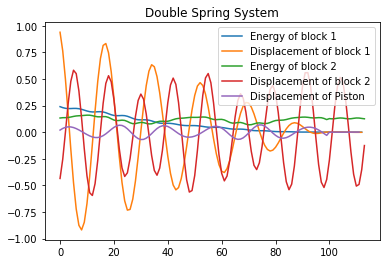

In [ ]:
d = zero_pad_signal(result.x, zero_padding_length + 10)
[es, xs, vs] = simulate_two(d, x,v,k,m,dt)
mid = int(len(es)/2 - 1)
plt.plot(es[:mid], label='Energy of block 1')
plt.plot(xs[:mid], label='Displacement of block 1')
plt.plot(es[mid+1:], label='Energy of block 2')
plt.plot(xs[mid+1:], label='Displacement of block 2')
plt.plot(d, label='Displacement of Piston')
plt.title('Double Spring System')
plt.legend()

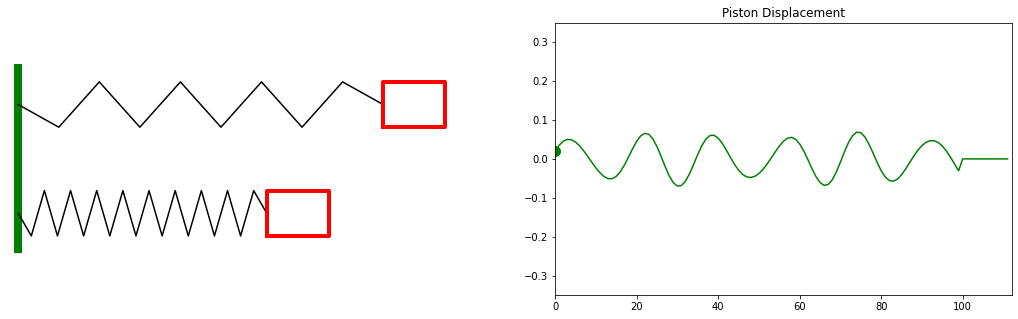

In [ ]:
#graphical parameters for drawing the springs and blocks
spring_points = 10
spring_points2 = 20
block_width = .5

fig = plt.figure(figsize=(18,5))
ax = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

piston, = ax.plot([], 'g-', lw=8)
spring, = ax.plot([], 'k-')
spring2, = ax.plot([], 'k-')
mass, = ax.plot([], 'r-', lw=4)
mass2, = ax.plot([], 'r-', lw=4)

ax.set_xlim((np.min(d), np.max(xs)+np.max(d) + np.max(l) + block_width + .1))
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

ax2.set_xlim((0,len(d)))
ax2.set_ylim((np.min(d)*5,-np.min(d)*5))
ax2.set_title('Piston Displacement')
ax2.plot(d, 'g')

pt, = ax2.plot([], 'go', ms=10)

spring_y = np.zeros(spring_points)
for i in range(1, spring_points - 1):
    spring_y[i] += .25*(-1)**(i%2)
spring_y += block_width*1.2

spring_y2 = np.zeros(spring_points2)
for i in range(1, spring_points2-1):
    spring_y2[i] += .25 * (-1)**(i%2)
spring_y2 += -1*block_width*1.2

#update method to be input into FuncAnimation
def update(i):
    pt.set_data([i], [d[i]])

    piston.set_data([d[i], d[i]], [-1,1])

    mass_x = np.full(5, d[i] + xs[i] + l[0])
    mass_x[2:4] += block_width
    mass_y = np.array([-1*block_width / 2, block_width/2, block_width/2, -1*block_width/2, -1*block_width/2]) + block_width*1.2

    mass.set_data(mass_x, mass_y)

    mass_x = np.full(5, d[i] + xs[signal_length + i] + l[1])
    mass_x[2:4] += block_width
    mass_y = np.array([-1*block_width / 2, block_width/2, block_width/2, -1*block_width/2, -1*block_width/2]) - block_width*1.2

    mass2.set_data(mass_x, mass_y)

    spring_x = np.linspace(d[i], d[i] + xs[i] + l[0], spring_points)

    spring.set_data(spring_x, spring_y)

    spring_x2 = np.linspace(d[i], d[i] + xs[signal_length + i] + l[1], spring_points2)

    spring2.set_data(spring_x2, spring_y2)

    return (piston,spring,mass, spring2, mass2)

ani = FuncAnimation(fig, update, frames=np.arange(len(d)), blit=True, repeat=False)

In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video())

As expected, the optimal signal looks a bit more complicated. You can imagine many more optimal control problems analagous to these simply by adding more blocks and springs. Even for much more complicated physical systems, the general method used in this notebook can be used to solve any optimal control problem.